In [3]:
import Pkg; Pkg.instantiate()
Pkg.activate(".")
using DrugResponseModel
using Plots, LinearAlgebra
concs, populations1, g1s1, g2s1 = load(189, 1);
concs, populations2, g1s2, g2s2 = load(189, 2);
concs, populations3, g1s3, g2s3 = load(189, 3);
g0 = g1s1[1,1,1]+g2s1[1,1,1];

g1avg = (g1s1 .+ g1s2 .+ g1s3) ./ 3; # pure data
g2avg = (g2s1 .+ g2s2 .+ g2s3) ./ 3; # pure data

#---- traditional approach
BlissOnData = blissCellNum(g1avg, g2avg; T=96, n=8)
#----

#---- our approach
paramAvg = p= [49.2322, 1.13253, 0.0557782, 3.43847, 0.0183834, 0.0530674, 0.538046, 
               58.3661, 1.7259, 2.69584, 0.0578749, 0.475825, 0.537772, 0.544677, 
               20.8855, 2.05741, 2.05982, 4.99875, 0.0697081, 0.359285, 0.496691, 
               3.9771, 4.8181, 0.0587329, 1.82322, 0.633786, 0.445822, 0.498424, 
               40.3828, 1.08046, 0.653381, 3.35693, 0.0426125, 0.0648354, 0.535886, 
               1.92651, 1.77876, 42.2714, 56.3408, 37.3421, 17.6778];

efcs = getODEparamsAll(paramAvg, concs);

 Activating environment at `~/ODE/DrugResponseModel.jl/Project.toml`
┌ Info: Precompiling DrugResponseModel [f46a7e40-ab32-11e9-0ff4-0323d592fbfd]
└ @ Base loading.jl:1278


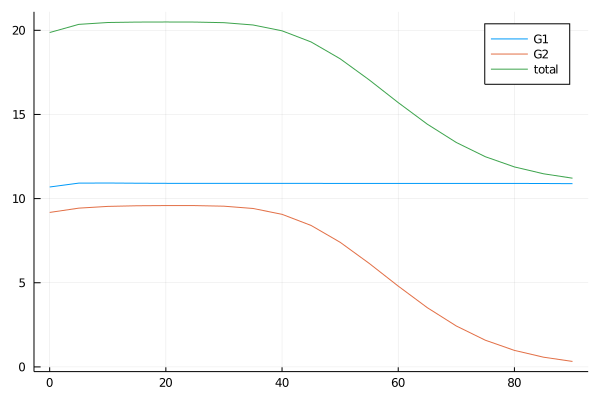

In [20]:
EC50s = [paramAvg[1], paramAvg[8], paramAvg[15], paramAvg[22], paramAvg[29]]

function paramsAtEC50(p)
    ps = zeros(9, 5) # num_parameters x number of drugs.
    k = 1
    for i =1:5
        ps[:, i] = [0.5*(p[36] + p[k + 2]), 0.5*(p[37] + p[k + 3]), 0.5*p[k + 4], 0.5*p[k + 5], p[k + 6], floor(p[38]), floor(p[39]), floor(p[40]), floor(p[41])]
        k += 7
    end
    return ps
end

params = paramsAtEC50(paramAvg)

function BlissUnit(p1, p2)
    # p1 and p2 are Arrays 9x1 and are assumed to be from the EC50 concentration.
    combin = similar(p1)
    combin[1:2] .= p1[1:2] .+ p2[1:2] .- p1[1:2] .* p2[1:2]
    combin[3:4] .= p1[3:4] .+ p2[3:4]
    combin[5:end] .= p1[5:end]
    return combin
end

combin = BlissUnit(params[:, 1], params[:, 2]) # lpt and dox

tim = 0.0:5:90.0
G1, G2 = predict(combin, g1avg[1] + g2avg[1], tim)

plot(tim, G1, label="G1")
plot!(tim, G2, label="G2")
plot!(tim, G1 .+ G2, label="total")

In [7]:
function BlissUnit(p1, p2)
    # p1 and p2 are Arrays 9x1 and are assumed to be from the EC50 concentration.
    combin = similar(p1)
    combin[1:2] .= p1[1:2] .+ p2[1:2] .- p1[1:2] .* p2[1:2]
    combin[3:4] .= p1[3:4] .+ p2[3:4]
    combin[5:end] .= p1[5:end]
    return combin
end
p1 = efcs[:, 1, 1]
p2 = efcs[:, 1, 2]

9-element Array{Float64,1}:
  1.9265139124255026
  1.7787512484437724
  2.419806669230713e-6
  2.7348379595976235e-6
  0.544677
 42.2714
 56.3408
 37.3421
 17.6778

In [8]:
BlissUnit(p1, p2)

9-element Array{Float64,1}:
  0.14228143788423564
  0.3930133266623894
  9.90616145525982e-6
  2.43457142921651e-5
  0.538046
 42.2714
 56.3408
 37.3421
 17.6778